<a href="https://colab.research.google.com/github/priya1016/NLP/blob/main/18_neural_nets_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 18. Neural Networks II



# Lecture Activities 

Feel free to add cells to this notebook as you wish. Make sure to keep **code** and any **answers to questions** that you've written and turn in your notebook as a pdf at the end of the lecture. If you have not finished the exercises, don't worry, you can keep working on them until the end of the week.

All lecture notebooks for a given week must be submitted to Gradescope by **11 pm on Sundays**.

### Notebook submission

Follow these steps to convert your notebook into a pdf for submission: 
1. Kernel -> Restart & Run All (clear your kernel's memory and run all cells)
2. File -> Download As -> .html -> open in a browser -> print to pdf

(The download as pdf option doesn't preserve formatting and output as nicely as taking the step "through" html, but will do if the above doesn't work for you.)

### Priya Garg


## Task 1: Predict Word Sentiment

We'll start by trying to train our neural net from last time to recognize if a word is positive or negative based on its word embedding.


1. How many words were excluded from the train set because we didn't have vectors for them? What words were they?
  
  __433, mostly alphanumeric or containing special characters, all printed in task 1.1 cell__
2. What happens to the error over time as the model runs?
  
  __error decreases suddenly first and then saturates__
3. Based only on this, how well do you think that this model will perform? 

  __Since the error has saturated well, I expect the model to perform good__



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline
# seed random number generation so that you can 
# track the same numbers as each other

In [2]:
# we'll get our embeddings from the gensim package
import gensim.downloader

In [3]:
# go get some pre-trained word embeddings with 50 dimensions
# glove refers to a different algorithm for creating the vectors
# the resulting vectors follow the same structure:
# dense vectors representing words in n-dimensional space

# we're using this one because it's the smallest
# set available pre-trained from gensim
# 66 MB
word2vec_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [4]:
# accessing a specific word vector
print(word2vec_vectors['computer'])

[ 0.079084 -0.81504   1.7901    0.91653   0.10797  -0.55628  -0.84427
 -1.4951    0.13418   0.63627   0.35146   0.25813  -0.55029   0.51056
  0.37409   0.12092  -1.6166    0.83653   0.14202  -0.52348   0.73453
  0.12207  -0.49079   0.32533   0.45306  -1.585    -0.63848  -1.0053
  0.10454  -0.42984   3.181    -0.62187   0.16819  -1.0139    0.064058
  0.57844  -0.4556    0.73783   0.37203  -0.57722   0.66441   0.055129
  0.037891  1.3275    0.30991   0.50697   1.2357    0.1274   -0.11434
  0.20709 ]


In [48]:
def load_word_list(filename: str, label: int) -> list:
    """
    Loads a lexicon from a plain text file in the format of one word per line.
    Parameters:
    filename (str): path to file
    label (int): label to assign the items in the file

    Returns:
    list: list of words
    """
    # f = open(filename, "r", encoding="latin-1")
    # content = f.read()  # read all contents
    # f.close()  # close the file when you're done
    # lexicon = content.split('\n')

    # return lexicon

    with open(filename, 'r', encoding='utf-8') as f:
        # skip the header content
        # for line in f:
        #     # print((line.strip(),label))
        #     if line.strip() == "":
        #         print("breaking")
        #         break
        # read the rest of the lines into a list
        return [(line.strip(), label) for line in f]
        # f.close()
    # otherwise return an empty list
    return []

def reduplicate(lst: list, times: int = 1000) -> list:
    """
    Randomly reduplicates some number of elements of a list
    and adds them to the list as it goes. Mutator function.
    Parameters:
    lst (list): list of items to reduplicate
    times (int): number of times to reduplicate. Default to 1000.

    Returns:
    None
    """
    for i in range(times):
        lst.append(lst[random.randrange(0, len(lst))])

        
# Load in word lists
positives = load_word_list('data/positive_words.txt', 1)
negatives = load_word_list('data/negative_words.txt', 0)

# randomly re-duplicate some of the examples
reduplicate(positives)
reduplicate(negatives)

# artifically balance the sets so we have the
# same number of negatives and positives
min_amt = min(len(positives), len(negatives))
positives = positives[:min_amt]
negatives = negatives[:min_amt]

# TODO: Make a training set with 90% of the examples 
# and a dev set with 10% of the examples
cut_off = int(min_amt*0.9)
train = positives[:cut_off] + negatives[:cut_off]
dev = positives[cut_off:] + negatives[cut_off:]


print("num in train:", len(train))
print("num in dev:", len(dev))

num in train: 5410
num in dev: 602


In [49]:
def relu(x):
    """
    Apply the rectified linear function (max(0, x)) to each value in
    an array of values.
    Parameters:
    x (array): array of values to apply function to

    Returns:
    numpy array of results
    """
    return np.maximum(0, x)


def relu_deriv(x):
    """
    Apply the derivative of the rectified linear function to each value in
    an array of values.
    Parameters:
    x (array): array of values to apply function to

    Returns:
    numpy array of results
    """
    x[x<=0] = 0
    x[x>1] = 1
    return x

def sigmoid(x):
    """
    Apply the sigmoid function to each value in
    an array of values.
    Parameters:
    x (array): array of values to apply function to

    Returns:
    numpy array of results
    """
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    """
    Apply the derivative of the sigmoid function to each value in
    an array of values.
    Parameters:
    x (array): array of values to apply function to

    Returns:
    numpy array of results
    """
    return sigmoid(x) * (1 - sigmoid(x))

In [50]:
#Task 1.1

# input should be in the format
def create_input_array(examples: list, word_vectors: gensim.models.keyedvectors.Word2VecKeyedVectors) -> np.array:
    """
    Convert examples to input and label arrays
    Parameters:
    examples (list): list of (word, label) tuples
    word_vectors (gensim.models.keyedvectors.Word2VecKeyedVectors): dense word vectors to match with words

    Returns:
    numpy array of inputs, numpy array of corresponding labels
    """
    labels = []
    X = []
    exclusions = []
    for ex in examples:
        word = ex[0]
        label = ex[1]
        # ignore words that we don't have vectors for
        if word in word_vectors:
            X.append(np.append(word_vectors[word], [1]))  # add in the bias term
            labels.append(label)
        else:
            exclusions.append(word)

    return np.array(X, dtype=np.float128), np.array([labels]).T, exclusions

X, y, exclusions = create_input_array(train, word2vec_vectors)
print("shape of inputs:", X.shape)
print("shape of labels:", y.shape)
print("number of excluded words: ", len(exclusions))
print(exclusions)

shape of inputs: (4977, 51)
shape of labels: (4977, 1)
number of excluded words:  433
['a+', 'accessable', 'achievible', 'adorer', 'adulate', 'afordable', 'agilely', 'amiabily', 'awsome', 'beautifullly', 'believeable', 'benifits', 'better-than-expected', 'beutifully', 'brilliances', 'cashbacks', 'contrasty', 'convience', 'convienient', 'convient', 'courageousness', 'danken', 'dead-cheap', 'deginified', 'delightfulness', 'dirt-cheap', 'dotingly', 'dummy-proof', 'ecenomical', 'elate', 'elatedly', 'enrapt', 'enrapture', 'enthral', 'enviousness', 'ergonomical', 'err-free', 'exaltedly', 'exaltingly', 'examplar', 'examplary', 'excallent', 'exceled', 'excelent', 'excellant', 'excitedness', 'exellent', 'exhilarate', 'exultingly', 'eye-catch', 'eyecatch', 'fancinating', 'favorited', 'fecilitous', 'fervidly', 'fine-looking', 'first-in-class', 'futurestic', 'geekier', 'god-send', 'goood', 'gooood', 'hands-down', 'heroize', 'hotcake', 'imaculate', 'inestimably', 'ingenuously', 'inpressed', 'invalu

In [51]:
# hyper parameters
# feel free to play with these!
hidden_units = 20
num_epochs = 500

In [52]:
# This is the same as the lecture 15 code

input_features = X.shape[1]
# initialize weights randomly with mean 0 and range [-1, 1]
W_dim = (input_features, hidden_units)

# you'll need to use W_dim and U_dim to produce the
# correct number of random numbers
W = np.array(2 * np.random.random(W_dim) - 1, dtype=np.float128)
# note that we are doing binary classification, 
# so the second dimension here is 1 
# (corresponding to one output unit)
U_dim = (hidden_units, 1)
U = np.array(2 * np.random.random(U_dim) - 1, dtype=np.float128)

# make sure these numbers make sense
print("W:", W.shape)
print("U:", U.shape)

W: (51, 20)
U: (20, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


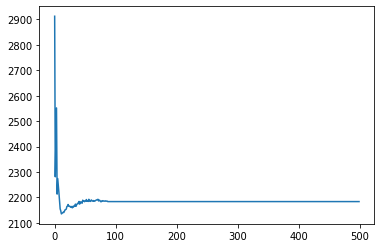

In [53]:
# Task 1.2 and 1.3

inputs = X

errors = []
for i in range(num_epochs):
    # forward propagation—sigmoid, relu, tanh, etc
    h = relu(np.dot(inputs,W))
    
    # always sigmoid—classification
    y_hat = sigmoid(np.dot(h,U))

    # print(y.shape)
    # print(y_hat.shape)
    # print(type(y[0]))
    # print(type(y_hat[0]))
    # how much did we miss?
    layer2_error = y - y_hat
    
    # what happens to our error as we go through epochs?
    errors.append(sum(np.abs(layer2_error)))
    
    # this is telling us how much to move
    # our weights and in what direction
    # use the corresponding derivative to the non-linearity used above
    layer2_delta = layer2_error * sigmoid_deriv(y_hat)

    # how much did each L1 value contribute to 
    # the L2 error (according to the weights)?

    layer1_error = layer2_delta.dot(U.T)
    
    # this is telling us how much to move
    # our weights and in what direction
    layer1_delta = layer1_error * relu_deriv(h)

    U += h.T.dot(layer2_delta)
    W += inputs.T.dot(layer1_delta)
    
plt.plot(range(num_epochs), errors)
plt.show()

In [54]:
def accuracy(y, y_hat):
    """
    Measure the accuracy of our model, print the results.
    Parameters:
    y (array): true labels
    y (array): model estimates
    Returns:
    None
    """
    count = 0
    for i in range(len(y)):
        guess = 1 if y_hat[i] > 0.5 else 0
        if guess == y[i]:
            count += 1
    print("Accuracy:", count / y.shape[0])

In [56]:
print("Output After Training:")
# these are the same as the inputs that we trained this net on
X_dev, y_dev,excl_test = create_input_array(dev, word2vec_vectors)

# assign labels to the test data
h = sigmoid(np.dot(X_dev,W))
y_hat = sigmoid(np.dot(h,U))

# These should match with each other
accuracy(y_dev, y_hat)

Output After Training:
Accuracy: 0.5469026548672566


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp




## Task 2: Predict Word Sentiment with Keras

Now, we'll use some NN libraries that can handle numbers with lots of decimal points much better to see what happens with this task.

Installation of component libraries (via `pip3`):

```
pip3 install tensorflow
sudo pip3 install keras
```


1. How well did your model do? Theories about any differences that you saw with the two models?

__The NN model (acc= ~89%) performed much better than previous model (acc= ~55%). Adding Dense layer is helpful as it captures the hidden context more.__

In [57]:
from keras.models import Sequential
from keras.layers import Dense

In [61]:
# set up the basis for a feed forward network
model = Sequential()
# hidden layer -- same number of hidden units as above
model.add(Dense(units=hidden_units, activation='relu', input_dim=X.shape[1]))
# output layer
model.add(Dense(units=1, activation='sigmoid'))

# configure the learning process
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])


model.fit(X, y, epochs=num_epochs, verbose=0)

In [62]:
#Task 2.1

y_hat = model.predict(X_dev)

accuracy(y_dev, y_hat)

18/18 [==============================] - 0s 2ms/step
Accuracy: 0.8902654867256637
